Задача бинарной классификации на большом корпусе imdb рецензий на фильмы. 
Корпус можно скачать по ссылке http://ai.stanford.edu/~amaas/data/sentiment/


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from sklearn.metrics import *
import numpy as np
from matplotlib import pyplot
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
!cp '/content/drive/My Drive/aclImdb_v1.tar.gz' '/content'

In [ ]:
import tarfile
tar = tarfile.open("/content/drive/My Drive/aclImdb_v1.tar.gz", "r")
tar.extractall()

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords 
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
stop_words = set(stopwords.words('english'))

def preprocess(rawtext):
    ans = ''
    for char in rawtext:
        if char.isalpha() or char == ' ':
            ans += char
        else:
            ans += ' '
    words = nltk.word_tokenize(ans)
    answer = []
    for w in words:
        w = lemmatizer.lemmatize(w.lower())
        if w not in stop_words and len(w)>2:
            answer.append(w.lower())
    
    return ' '.join(answer)

In [ ]:
import pandas as pd

def make_df(data, path_list, sent):
    idx = data.shape[0]
    for p, path in enumerate(path_list):
        with open(path, "r", encoding="utf-8") as w:
            raw = w.read()
        data.loc[idx, "rewiev"] = raw
        data.loc[idx, "sentiment"] = sent
        data.loc[idx, "processed"] = preprocess2(raw)
        idx+=1

In [ ]:
import os


def make_set(directories):
    data = pd.DataFrame(data=None, columns=['rewiev', 'sentiment', 'processed'])
    for directory in directories:
        path_list = []
        for root, dirs, files in os.walk(directory):
            for file in files:
                if file.endswith('.txt'):
                    path_list += [root + "/" + file]
        sent = directory.split('/')[-1]
        if sent == 'neg':
            make_df(data, path_list, 0)
        else:
            make_df(data, path_list, 1)
    return data
        

In [ ]:
test = make_set(["/content/aclImdb/test/neg", "/content/aclImdb/test/pos"])

In [ ]:
data = make_set(["/content/aclImdb/train/neg", "/content/aclImdb/train/pos"])

In [ ]:
data.head(10)

,rewiev,sentiment,processed
0,Lynch. The man has some really great stuff! He...,0,lynch man really great stuff know disturb rewa...
1,When the folks at Kino Video assembled their f...,0,folk kino video assembled fine slapstick encyc...
2,Tom is listening to one of those old-time radi...,0,tom listening one old time radio broadcast som...
3,"I really must watch a good movie soon, because...",0,really must watch good movie soon seems every ...
4,It was great to see some of my favorite stars ...,0,great see favorite star year ago including joh...
5,Despite the gravity of the subject and probabl...,0,despite gravity subject probably good intentio...
6,Even if this film was allegedly a joke in resp...,0,even film allegedly joke response critic still...
7,"I can sit through this movie once, but I doubt...",0,sit movie doubt could make second time mildly ...
8,"Mislead by the terrible lie on the cover, ""fun...",0,mislead terrible lie cover fun american pie gi...
9,Picture the scene where a bunch of scriptwrite...,0,picture scene bunch scriptwriter sit around ta...


In [ ]:
cv=CountVectorizer(ngram_range=(1,4))
cv_train=cv.fit_transform(data['processed'])
print(cv_train.shape)

(25000, 7291584)


In [ ]:
train_target = data['sentiment']
train_target = train_target.astype('int32')

In [ ]:
X_test = cv.transform(test['processed'])

In [ ]:
clf = LogisticRegression(max_iter=2000).fit(cv_train, train_target)

In [ ]:
test_target = test['sentiment']
test_target = test_target.astype('int32')

In [ ]:
predicted = clf.predict(X_test)

In [ ]:
acc = accuracy_score(test_target, predicted)
f = f1_score(test_target, predicted)
p = precision_score(test_target, predicted)
r = recall_score(test_target, predicted)
print('accuracy={0:1.4f}'.format(acc))
print('F={0:1.4f}, Precision={1:1.4f}, Recall={2:1.4f}'.format(f, p, r))

accuracy=0.8841
F=0.8842, Precision=0.8832, Recall=0.8853


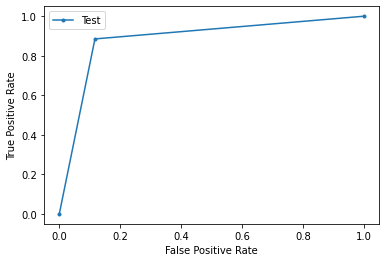

In [ ]:
y_true = np.array([0, 1, 1, 1, 0])
y_predicted = np.array([0.1, 0.867, 0.2, 0.3, 0.25])
fpr, tpr, thrhld = roc_curve(test_target, predicted)
pyplot.plot(fpr, tpr, marker='.', label='Test')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()

In [ ]:
print(roc_auc_score(test_target, predicted))

0.88408


Используя предсказания вероятностей класса, найдите 15 самых негативных и самых позитивных рецензий по мнению модели.  - 3 балла



In [ ]:
g=clf.predict_proba(X_test)
d = {}
for i,j in enumerate(g):
    d[i]=j

In [ ]:
sorted_d = sorted(d.items(), key=lambda x: x[1][0])

In [ ]:
pd.DataFrame([list(test['rewiev'][j] for j in list(i[0] for i in sorted_d[:15]))] , index = ['positive rewiev']).T

,positive rewiev
0,"This is a great German slasher, that's often q..."
1,This is actually great fun. I really enjoyed i...
2,This is one of Bruce's most underrated films i...
3,"Universal Studios version of ""Flipper"" (1996) ..."
4,This is a surprisingly great low budget Horror...
5,1904. The North African nation of Morocco is h...
6,"This is a solid underrated little thriller, th..."
7,"Tony Hawk's Pro Skater 2x, isn't much differen..."
8,I remember really liking BATMAN RETURNS when i...
9,Hayao Miyazaki's latest and eighth film for St...


In [ ]:
pd.DataFrame([list(test['rewiev'][j] for j in list(i[0] for i in sorted_d[-15:]))] , index = ['negative rewiev']).T

,negative rewiev
0,Interferencia starts as unemployed Martin Sand...
1,SPOILERS: The original Road House is one of th...
2,The Bone Collector is set in New York City & s...
3,A space ship cruising through the galaxy encou...
4,...the first? Killjoy 1. But here's the review...
5,"Plankton, or Creatures from the Abyss as I'm p..."
6,I watched the 219 minute version and have to s...
7,The review on the main page admits that the mo...
8,Komodo vs. Cobra starts as 'One Planet' enviro...
9,Rose  Does anything actually happen in this e...


Написать свои функции, которые бы считали tp, fp, tn, fn, и возвращали точность, полноту и ф-меру и применить их к результатам, полученным вашими классификаторами (если все сделано правильно, то результаты должны совпадать с полученными  sklearn метриками). - 3 балла

In [ ]:
def classification(test_target, pred):
    comp = pd.DataFrame([test_target, pred], index=['targ','pred']).T
    TP = comp[(comp.targ==1)&(comp.pred==1)].shape[0]
    TN = comp[(comp.targ==0)&(comp.pred==0)].shape[0]
    FP = comp[(comp.targ==0)&(comp.pred==1)].shape[0]
    FN = comp[(comp.targ==1)&(comp.pred==0)].shape[0]
    return(TP, TN, FP, FN)

In [ ]:
TP, TN, FP, FN = classification(test_target, predicted)

In [ ]:
acc1 = (TP+TN)/(TP+FP+FN+TN)
p1 = (TP)/(TP+FP)
r1 = (TP)/(TP+FN)
f1 = 2*p1*r1/(p1+r1)
print('accuracy={0:1.4f}'.format(acc1))
print('F={0:1.4f}, Precision={1:1.4f}, Recall={2:1.4f}'.format(f1, p1, r1))

accuracy=0.8841
F=0.8842, Precision=0.8832, Recall=0.8853


In [ ]:
(acc==acc1)&(p==p1)&(r==r1)&(f==f1)

True